# demo

这个notebook负责测试自己写的mydet包中的功能



### anchor.AnchorGenerator

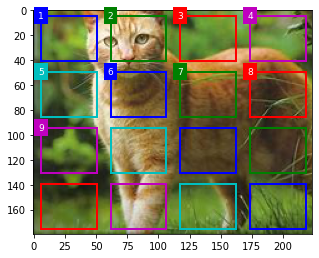

In [13]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from utils.bbox import show_bboxes
from mydet.anchor import AnchorGenerator

anchors = AnchorGenerator(
    sizes = [0.2],
    ratios = [1.]
).generate_anchors_prior(
    fmap_h = 4,
    fmap_w = 4
)

img = Image.open('image/cat.jpg')

img_np = np.array(img)
h, w, _ = img_np.shape
bbox_scale = torch.tensor([w, h, w, h], dtype=torch.float32)

# 显示图片
plt.figure(figsize=(5, 5))
plt.imshow(img)
show_bboxes(
    plt.gca(),
    anchors.squeeze(0) * bbox_scale,
    ['1', '2', '3', '4', '5', '6', '7', '8', '9']
)

    

### anchor.BBoxPostProcessor

In [14]:
from mydet.bbox.postprocessor import BBoxPostProcessor

In [15]:
anchors = torch.tensor([
    [0.1, 0.08, 0.52, 0.92], 
    [0.08, 0.2, 0.56, 0.95],
    [0.15, 0.3, 0.62, 0.91], 
    [0.55, 0.2, 0.9, 0.88]
]) # 一共四个锚框
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([
    [0] * 4,               # 背景的预测概率
    [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
    [0.1, 0.2, 0.3, 0.9]   # 猫的预测概率
])  # 一共三类，其中第一类为背景

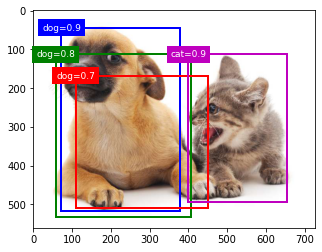

In [16]:
img = Image.open('image/catdog.jpg')
fig = plt.imshow(img)
img_np = np.array(img)
h, w, _ = img_np.shape
bbox_scale = torch.tensor([w, h, w, h], dtype=torch.float32)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [17]:
bbox_scale

tensor([728., 561., 728., 561.])

tensor([[[ 0.0000,  0.9000,  0.1000,  0.0800,  0.5200,  0.9200],
         [ 1.0000,  0.9000,  0.5500,  0.2000,  0.9000,  0.8800],
         [-1.0000,  0.8000,  0.0800,  0.2000,  0.5600,  0.9500],
         [-1.0000,  0.7000,  0.1500,  0.3000,  0.6200,  0.9100]]])


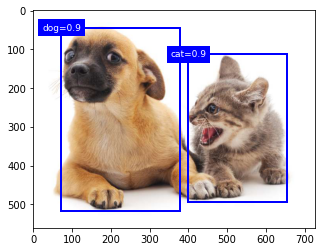

In [18]:
output = BBoxPostProcessor(
    nms_threshold=0.5,
    neg_threshold=0.009,
).multibox_detection(
    cls_probs.unsqueeze(dim=0),
    offset_preds.unsqueeze(dim=0),
    anchors.unsqueeze(dim=0)
)
print(output)

fig = plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

### 从头开始测试一下网络

在这一部分，我们将从头开始测试一下网络，看看网络的输出是否正确。

In [19]:
from mydet.backbone import Backbone
from mydet.neck import Neck
from mydet.head import Head

In [20]:
X = torch.randn(size=(1, 3, 256, 256))

In [21]:
backbone = Backbone(model='resnet101')
backbone._freeze_backbone()
neck = Neck()
head = Head(
    stacked_convs=2,
)

d:\anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
backbone_out = backbone(X)
print(backbone_out[0].shape)
print(backbone_out[1].shape)
print(backbone_out[2].shape)
print(backbone_out[3].shape)

torch.Size([1, 256, 64, 64])
torch.Size([1, 512, 32, 32])
torch.Size([1, 1024, 16, 16])
torch.Size([1, 2048, 8, 8])


In [23]:
neck_out = neck(backbone_out)
print(neck_out[0].shape)
print(neck_out[1].shape)
print(neck_out[2].shape)
print(neck_out[3].shape)
print(neck_out[4].shape)

torch.Size([1, 256, 64, 64])
torch.Size([1, 256, 32, 32])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 4, 4])


In [24]:
head_out = head(neck_out)
print(head_out[0].shape)
print(head_out[1].shape)
print(head_out[2].shape)

torch.Size([1, 21824, 4])
torch.Size([1, 21824, 22])
torch.Size([1, 87296])


### 定义网络

In [25]:
class R50_FPN_SSD(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = Backbone(model='resnet50')
        self.neck = Neck()
        self.head = Head()

    def forward(self, X):
        backbone_out = self.backbone(X)
        neck_out = self.neck(backbone_out)
        head_out = self.head(neck_out) # anchor, cls, offset
        return head_out

In [26]:
from torchinfo import summary

model = R50_FPN_SSD()
summary(model, input_size=(1, 3, 256, 256))

d:\anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
d:\anaconda\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage())

Layer (type:depth-idx)                             Output Shape              Param #
R50_FPN_SSD                                        [1, 21824, 4]             --
├─Backbone: 1-1                                    [1, 256, 64, 64]          --
│    └─ResNet: 2-1                                 --                        2,049,000
│    │    └─Conv2d: 3-1                            [1, 64, 128, 128]         (9,408)
│    │    └─BatchNorm2d: 3-2                       [1, 64, 128, 128]         (128)
│    │    └─ReLU: 3-3                              [1, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-4                         [1, 64, 64, 64]           --
│    │    └─Sequential: 3-5                        [1, 256, 64, 64]          (215,808)
│    │    └─Sequential: 3-6                        [1, 512, 32, 32]          (1,219,584)
│    │    └─Sequential: 3-7                        [1, 1024, 16, 16]         (7,098,368)
│    │    └─Sequential: 3-8                        [1, 2048, 8, 8]         